# Many Body Participation of TFIM

In the periodically driven TFIM, we can, after Jordan-Wigner Transformation, get the following Hamiltonian
\begin{equation*}
H(t) =\sum_{k} \psi_{k}^{\dagger} 
\left(
\begin{array}{cc}
\left[h_0 + h_D \cos{\left(\omega_D t\right)}\right]+ J\cos{k} & J\sin{k}\\
J\sin{k} & -\left[h_0 + h_D \cos{\left(\omega_D t\right)}\right]- J\cos{k}
\end{array}
\right)
\psi_{k}.
\end{equation*}
The $2^N$ Floquet States (for $N$ spins) are given by products of Cooper-Pair states
\begin{equation*}
\vert\phi\rangle = \prod_k \left(u_k + v_k c^\dagger_k c^\dagger_{-k}\right)\vert 0\rangle .
\end{equation*}
Thus, the Cooper-Pair density matrix (TPDM: Two-Particle density matrix) is given by
\begin{align*}
\rho_{kq} &= \langle\phi\vert c^\dagger_{k} c^\dagger_{-k} c_q c_{-q} \vert \phi\rangle \\
           &= \langle 0 \vert \left(u^\ast_k + v^\ast_k c_{-k} c_{k}\right)\left(u^\ast_q + v^\ast_k c_{-q} c_{q}\right)\;c^\dagger_{k} c^\dagger_{-k} c_q c_{-q}\left(u_k + v_k c^\dagger_k c^\dagger_{-k}\right)\left(u_q + v_q c^\dagger_q c^\dagger_{-q}\right)\vert 0 \rangle .
\end{align*}
Note that, since there are four Floquet States for each $k, -k, q, -q$ set, there are $4^N$ such matrices. For simplicity, let us choose only the 'Half-filled' case, where $u_k, v_k, u_q, v_q$ are taken from the Floquet states with smaller of the two quasienergies. Performing the Wick contractions symbolically using sympy (see code cell below), the expression above simplifies to 
\begin{equation*}
\rho_{kq} = - v^\ast_k u_k \; u^\ast_q v_q - \delta_{kq}\left(|u_k\;v_q|^2 + |u_q\;v_k|^2 + u^\ast_k v_k v^\ast_q u_q\right) + \delta_{-kq}\left(|u_k\;v_q|^2 + |u_q\;v_k|^2 - u^\ast_k v_k v^\ast_q u_q\right)
\end{equation*}
Once the $u_k, v_k, u_q, v_q$ are evaluated numerically for each $k, -k, q, -q$ set, the TPDM can be diagonalized, yielding eigensystem
\begin{equation*}
\rho \vert \phi_k\rangle = n_k \vert \phi_k\rangle
\end{equation*}
The eigenstates $\vert \phi_\alpha\rangle$ have components $\phi_\alpha(i)$. For  each momentum $k$, the IPR now is 
\begin{equation*}
\phi_{IPR}(k) = \sum_{i}\vert\phi_k(i)\vert^4
\end{equation*}

In [59]:
from IPython.display import display, Math
import sympy
from sympy import I, simplify, expand, exp, KroneckerDelta
from tqdm import tqdm

from sympy.physics.secondquant import F as C, Fd as Cd
from sympy.physics.secondquant import FKet, FBra
from sympy.physics.secondquant import _apply_Mul as apply_mul
from sympy.physics.secondquant import wicks
from sympy.physics.secondquant import FermionicOperator as FO


uk = sympy.Function(r'u_k', commutative=True)
vk = sympy.Function(r'v_k', commutative=True)
uq = sympy.Function(r'u_q', commutative=True)
vq = sympy.Function(r'v_q', commutative=True)

k = sympy.Symbol('k', real=True, above_fermi=True)
mk = sympy.Symbol('-k', real=True, above_fermi=True)
q = sympy.Symbol('q', real=True, above_fermi=True)
mq = sympy.Symbol('-q', real=True, above_fermi=True)


def PhiKet(u,v, k, mk):
    return   u(k)  + v(k) * Cd(k) * Cd(mk) 

def PhiBra(u,v, k, mk):
    return  u(k). conjugate() +  C(mk) * C(k) * v(k).conjugate() 

r_kq = expand(PhiBra(uk, vk, k, mk) * PhiBra(uq, vq, q, mq) *\
                Cd(k)*Cd(mk)*C(q)*C(mq) * PhiKet(uk, vk, k, mk) *\
                                                PhiKet(uq, vq, q, mq))

rkq = wicks(r_kq,keep_only_fully_contracted=True).\
            subs(KroneckerDelta(k,mk),0).\
                subs(KroneckerDelta(q,mq),0).\
                    subs(KroneckerDelta(mk,mq),KroneckerDelta(k,q)).\
                        subs(KroneckerDelta(mk,q),KroneckerDelta(mq,k))
display(rkq)

u_k(k)*v_q(q)*conjugate(u_k(k))*conjugate(v_q(q))*KroneckerDelta(-q, k) - u_k(k)*v_q(q)*conjugate(u_k(k))*conjugate(v_q(q))*KroneckerDelta(k, q) - u_k(k)*v_q(q)*conjugate(u_q(q))*conjugate(v_k(k)) + 2*u_q(q)*v_k(k)*conjugate(u_k(k))*conjugate(v_q(q))*KroneckerDelta(-q, k)*KroneckerDelta(k, q) - u_q(q)*v_k(k)*conjugate(u_k(k))*conjugate(v_q(q))*KroneckerDelta(-q, k) - u_q(q)*v_k(k)*conjugate(u_k(k))*conjugate(v_q(q))*KroneckerDelta(k, q) + u_q(q)*v_k(k)*conjugate(u_q(q))*conjugate(v_k(k))*KroneckerDelta(-q, k) - u_q(q)*v_k(k)*conjugate(u_q(q))*conjugate(v_k(k))*KroneckerDelta(k, q)

In [219]:
%%time
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve 
from qutip.floquet import floquet_modes

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)


def get_sxt(k, nT, params, ntimes=1000, initstate=sigmaz().groundstate()[1]):
    sx = sigmax()
    sz = sigmaz()

    # construct the hamiltonian
    H0 = np.sin(k) * sx + np.cos(k) * sz
    H1 = sz
    
    H = [H0,[H1,drive]]   
    T = 2 * np.pi/params['omega']
    times = np.linspace(0, nT * T, ntimes)
    return mesolve(H, initstate, times, e_ops=[sz], args=params)

def get_floquet_isingfermion(k, args, **kwargs):
    
    sx = sigmax()
    sz = sigmaz()
    
    # construct the hamiltonian
    H0 = np.sin(k) * sx + np.cos(k) * sz
    H1 = sz
    
    H = [H0,[H1,drive]]    
    T = 2 * np.pi/args['omega']

    return floquet_modes(H, T, args, **kwargs)

def get_uv(k, params):
    f_states, f_energies = get_floquet_isingfermion(k, params, sort=True)
    return f_states[-1].full().flatten()

def get_rho(args):
    kq,params = args
    k,q = kq
    uk, vk = get_uv(k, params)
    uk_c, vk_c = np.conjugate(uk),np.conjugate(vk)
    
    uq, vq = get_uv(q, params)
    uq_c, vq_c = np.conjugate(uq),np.conjugate(vq)
    
    rho_matelem = vk_c * uk * uq_c * vq
    if k == 0 or q == 0:
        rho_matelem = 0.0
    elif k == q:
        rho_matelem -= np.abs(uk * vq)**2 + np.abs(uq * vk)**2 + uk_c * vk * vq_c * uq
    elif k == -q:
        rho_matelem += np.abs(uk * vq)**2 + np.abs(uq * vk)**2 - uk_c * vk * vq_c * uq
    return rho_matelem

CPU times: user 1.3 ms, sys: 131 µs, total: 1.43 ms
Wall time: 1.39 ms


In [223]:
%%time
import itertools, h5py
from qutip import parfor
from scipy.special import j0, jn_zeros

N=10000
num_cpus=6

h0 = 0.0
omega = 20.0
eta = jn_zeros(0,10)[0]
h = eta * omega/2
print(h,omega)

fname="many_body_iprs_TFIM.hdf5"

fbz = np.linspace(-np.pi, np.pi, N)
kq_pairs = [x for x in itertools.combinations(fbz, 2)]

with h5py.File(fname,"a") as f:
    params = {'h0':h0, 'h':h, 'omega':omega}
    arglist = [(kq, params) for kq in kq_pairs]
    rholist = parfor(get_rho, arglist, num_cpus=num_cpus)
    rho = np.zeros((N,N), dtype=np.complex128)
    for ri, kq in enumerate(kq_pairs):
        k, q = kq
        i, = np.where(fbz==k)
        j, = np.where(fbz==q)
        rho[i,j] = rholist[ri]
    rho = rho + np.conjugate(rho.T)
    n, phis = np.linalg.eig(rho)

    iprs =  np.sum(np.abs(phis)**4, axis=0)
    
    ipr_dataset = f.create_dataset("iprs", data=np.vstack([fbz,iprs]).T)
    ipr_dataset.attrs['nspins'] = N
    ipr_dataset.attrs['h0'] = h0
    ipr_dataset.attrs['h'] = h
    ipr_dataset.attrs['omega'] = omega
    ipr_dataset.attrs['j0_val'] = j0(2*h/omega)

24.04825557695773 20.0
CPU times: user 250 ms, sys: 309 ms, total: 559 ms
Wall time: 8.18 s


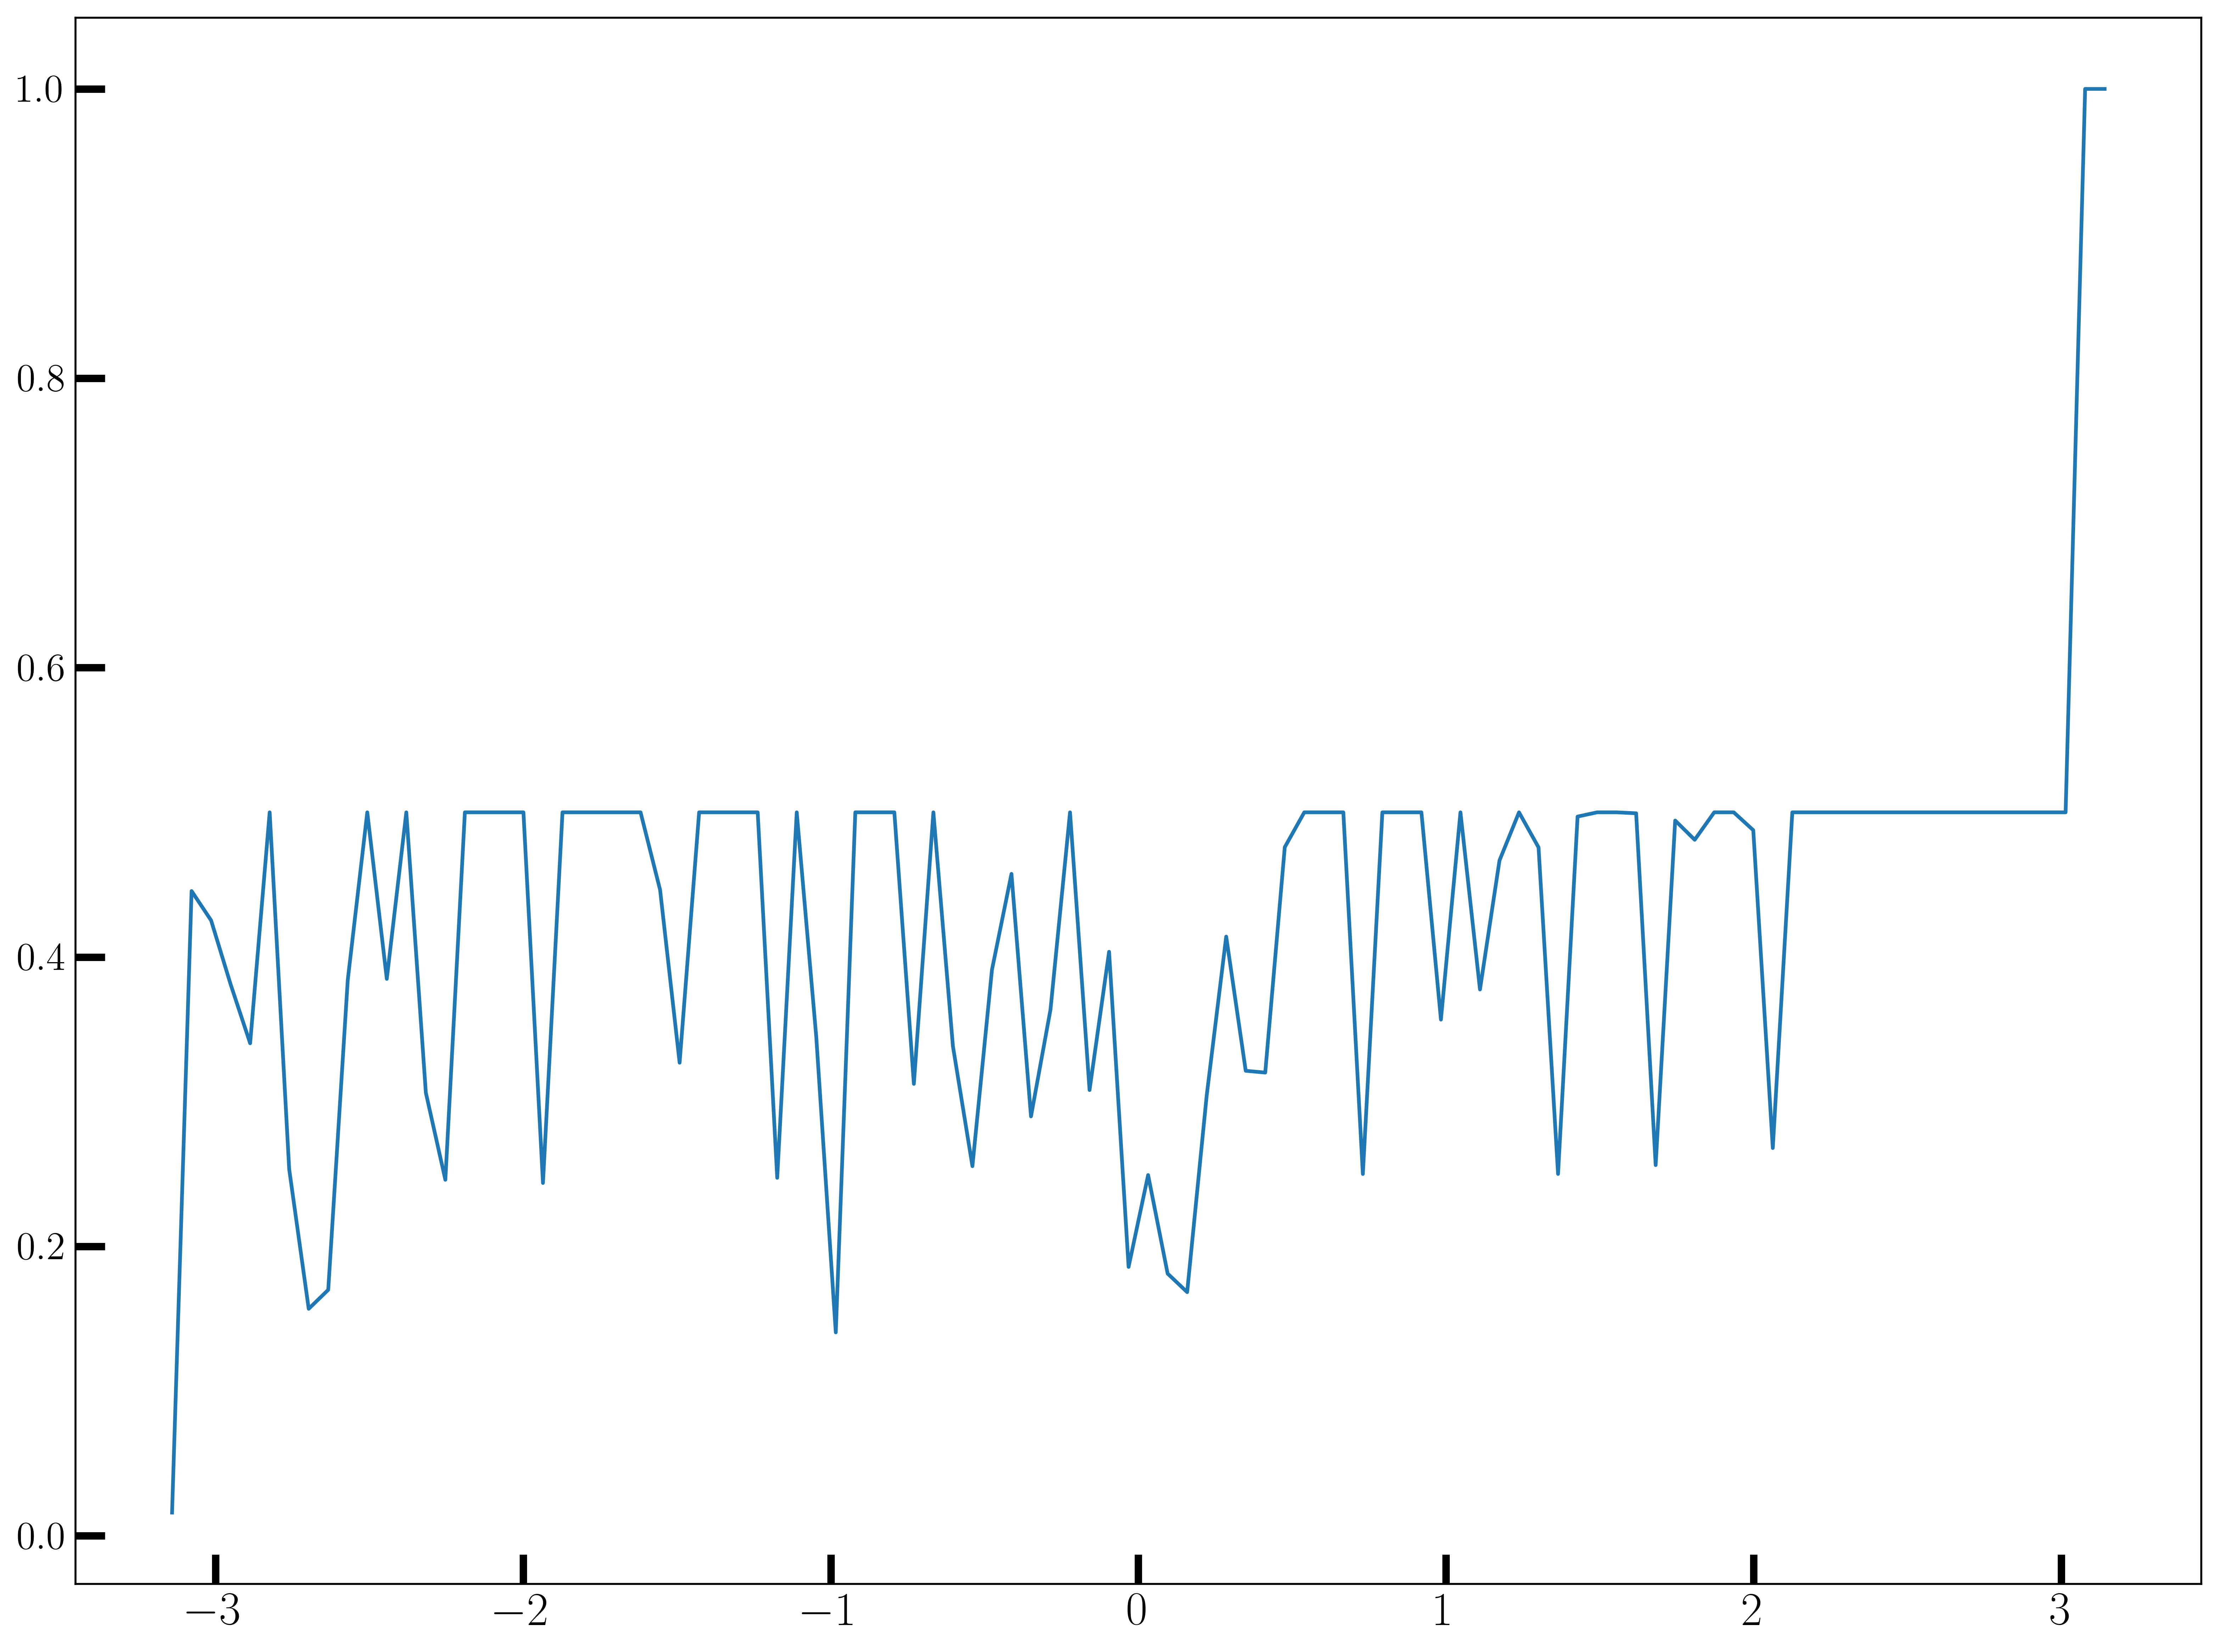

In [224]:
import matplotlib.pyplot as plt
import h5py
fname="many_body_iprs_TFIM.hdf5"
with h5py.File(fname, "r") as f:
    data = np.array(f["iprs"])
                       
plt.plot(data[:,0], data[:,1])
plt.show()

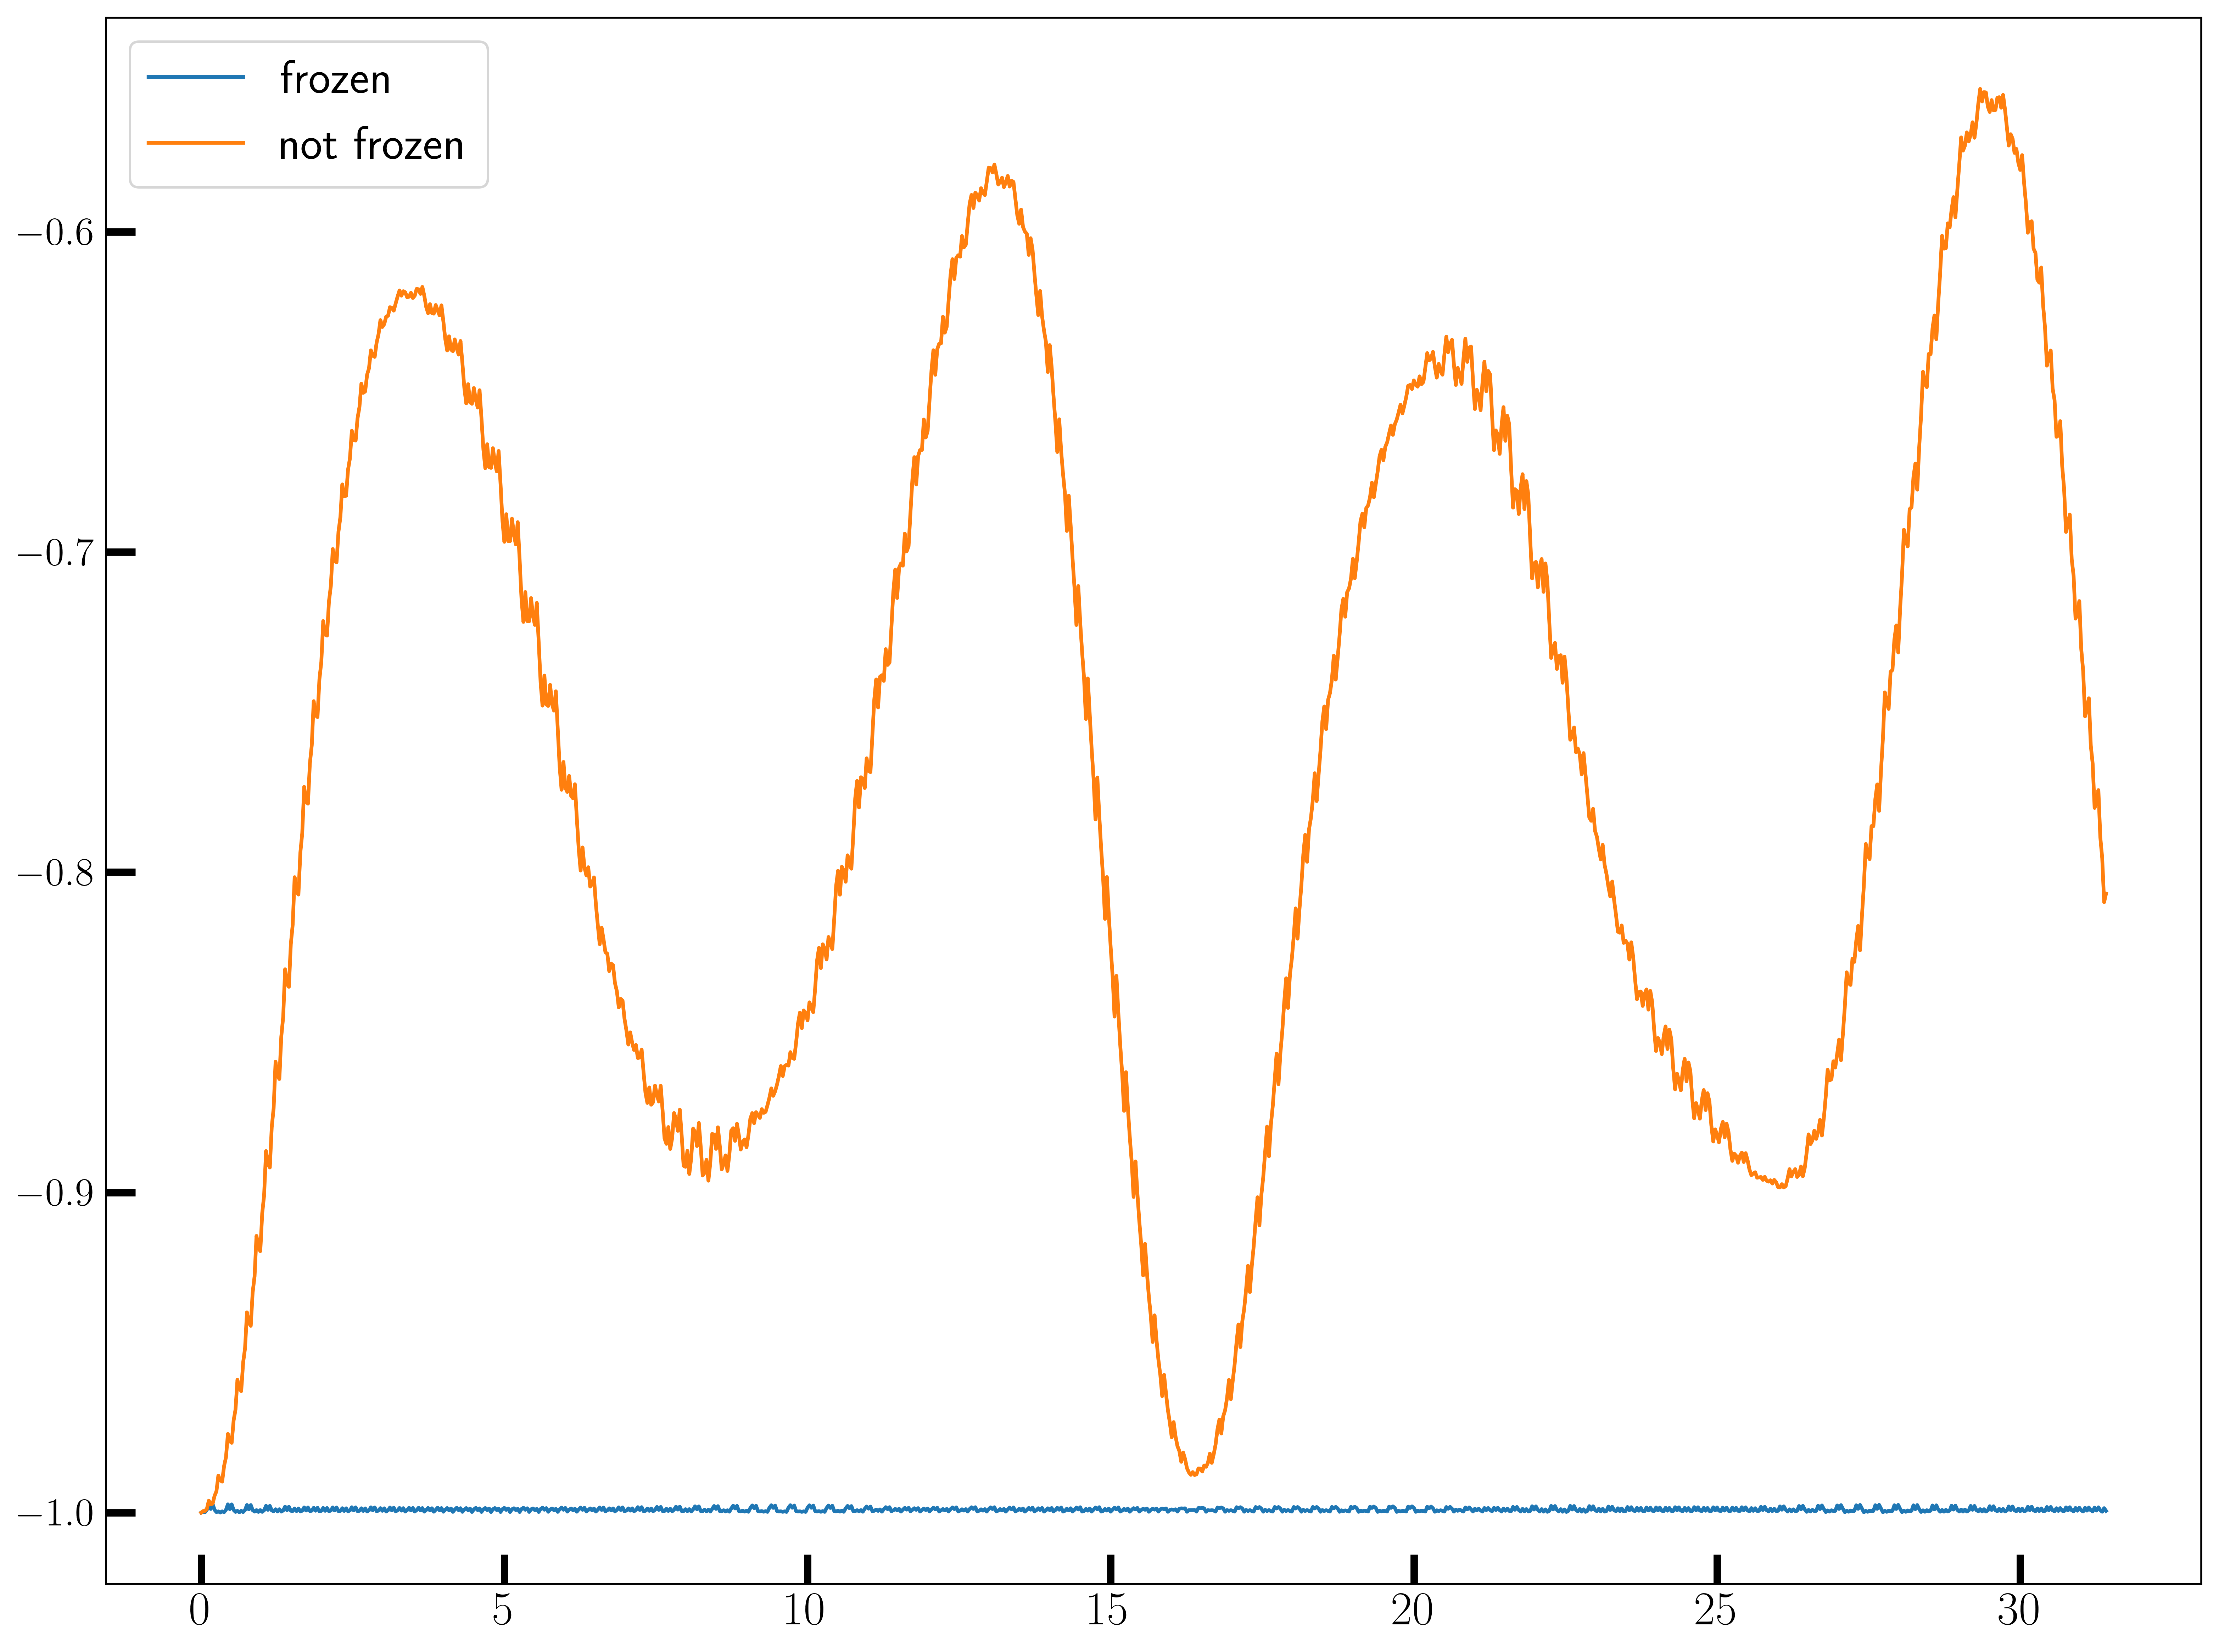

CPU times: user 5.42 s, sys: 331 ms, total: 5.75 s
Wall time: 5.46 s


In [227]:
%%time
import matplotlib.pyplot as plt

N=10
num_cpus=6

h0 = 0.0
omega = 20.0
eta = jn_zeros(0,10)[1]
h = eta * omega/2


fbz = np.linspace(-np.pi, np.pi, N)

params = {'h0':h0, 'h':h, 'omega':omega}

sols = [get_sxt(k,100, params) for k in fbz]

szvals = np.array([sol.expect[0] for sol in sols])


sztot=np.average(szvals, axis=0)

plt.plot(sols[0].times, sztot,label="frozen")


h = eta * omega/2.5

params = {'h0':h0, 'h':h, 'omega':omega}

sols = [get_sxt(k,100, params) for k in fbz]

szvals = np.array([sol.expect[0] for sol in sols])


sztot=np.average(szvals, axis=0)

plt.plot(sols[0].times, sztot, label="not frozen")
plt.legend()
plt.show()